In [1]:
 current_dir = "/content/gdrive/My Drive/Colab Notebooks/Thesis"
 target_dir = "/content/gdrive/My Drive/Colab Notebooks/Thesis/Politicians"

In [2]:
import os
from google.colab import drive
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
#import fasttext
import numpy as np
from sklearn.preprocessing import MinMaxScaler
drive.mount('/content/gdrive')
os.chdir(current_dir)

Mounted at /content/gdrive


In [3]:
ls

 cc.en.300.bin      lilienfeld_baselines.ipynb     Meetings/     'Sound Files'/
 cc.en.300.bin.gz   lilienfeld_samples_df.pickle   Politicians/  'Thesis Reports'/


In [11]:
import pandas as pd
import pickle

# Load the pickled DataFrame
with open('lilienfeld_samples_df.pickle', 'rb') as f:
    loaded_df = pickle.load(f)
    shuffled_data = loaded_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Now "loaded_df" contains the DataFrame that was previously pickled
for index,row in loaded_df.iterrows():
  print(row["presidents"], len(row["texts"].split()))

John F. Kennedy 809
Franklin D. Roosevelt 283
Ronald Reagan 749
William Jefferson Clinton 685
George W. Bush 399
Dwight D. Eisenhower 576
Lyndon B. Johnson 586
Gerald Ford 507
James Earl Carter 411
Richard Nixon 1551
George H. Bush 1025
Harry S. Truman 970
Herbert Hoover 1500


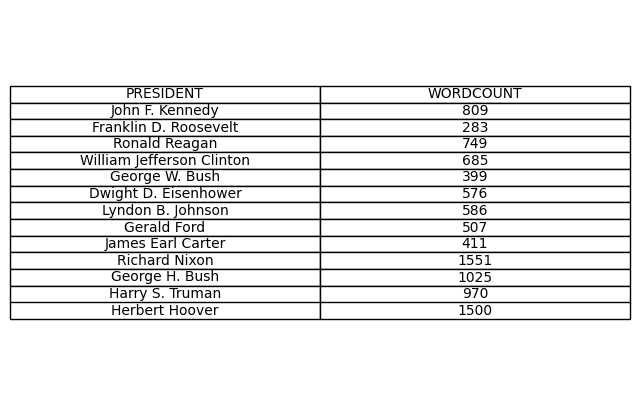

In [20]:
import matplotlib.pyplot as plt

data = {
    "President": ["John F. Kennedy", "Franklin D. Roosevelt", "Ronald Reagan", "William Jefferson Clinton",
                  "George W. Bush", "Dwight D. Eisenhower", "Lyndon B. Johnson", "Gerald Ford",
                  "James Earl Carter", "Richard Nixon", "George H. Bush", "Harry S. Truman", "Herbert Hoover"],
    "WordCount": [809, 283, 749, 685, 399, 576, 586, 507, 411, 1551, 1025, 970, 1500]
}

fig, ax = plt.subplots(figsize=(8, 5))

ax.axis('tight')
ax.axis('off')
table_data = []
for i in range(len(data["President"])):
    table_data.append([data["President"][i], data["WordCount"][i]])
ax.table(cellText=table_data, colLabels=["President".upper(), "WordCount".upper()], cellLoc='center', loc='center')

plt.show()



In [30]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset into the 'data' DataFrame

data = shuffled_data




X = data["texts"]
y = data["scores"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
rf_regressor = RandomForestRegressor()

# Create a FeatureUnion for text processing
text_processing = FeatureUnion([
    ('tfidf', tfidf_vectorizer),
])

pipeline = Pipeline([
    ('processing', text_processing),
    ('rf', rf_regressor)
])

# Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'processing__tfidf__max_features': randint(1000, 5000),
    'processing__tfidf__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': randint(100, 1000),
    'rf__max_depth': randint(10, 50),
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',  # Use appropriate scoring metric
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model on the training data
random_search.fit(X_train, y_train)

y_pred = random_search.predict(X_test)
# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

print(y_test)
print(y_pred)

Mean Squared Error (MSE): 0.2813332291604737
R-squared (R²): -0.06362471947276771
11    0.569
9     0.157
0    -0.668
Name: scores, dtype: float64
[0.20102155 0.37246121 0.14573707]
